# Log-Normal distribution

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
S0 = 100
r = 0.05
sigma = 0.25
T = 2.0
I = 10_000

def ST(t: float, S0: float = S0, size=I) -> float:
    return S0 * np.exp((r - 0.5 * sigma ** 2) * t + sigma * np.sqrt(t) * npr.standard_normal(size))

def describe(xs: float) -> None:
    print("mean:", xs.mean().round(3), "std:", xs.std().round(3))

def hist(xs) -> None:
    plt.hist(xs, bins=50)
    plt.show()

mean: 110.223 std: 40.626


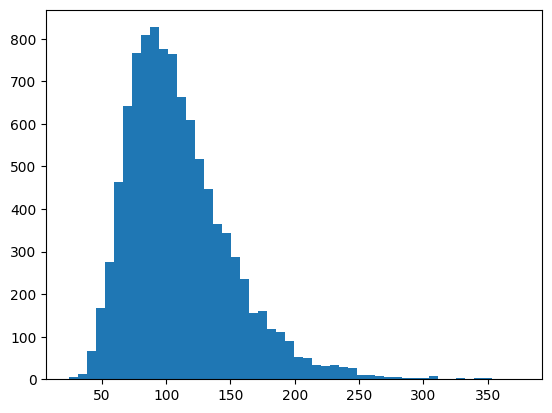

In [3]:
x = ST(2)
describe(x)
hist(x)

In [4]:
T = 1.0
mu = (r - 0.5 * sigma ** 2) * T
sigma = sigma * np.sqrt(T)
x2 = S0 * npr.lognormal(mu, sigma, size=I)
print("mu=", mu)
print("sigma=", sigma)
describe(x2)

mu= 0.018750000000000003
sigma= 0.25
mean: 104.572 std: 26.276


# Step-wise Simulation of Log-Normal Returns
1. In a loop

In [5]:
I = 10_000
M = 50
dt = T / M
S = np.zeros((M + 1, I))
S[0] = S0
for t in range(1, M + 1):
    S[t] = ST(S0=S[t - 1], t=dt)

In [6]:
print(S.shape)
describe(S[-1])

(51, 10000)
mean: 104.902 std: 26.373


2. Replacing the loop with a vectorized version and `np.cumprod()`

In [7]:
S2 = np.vstack([S0 * np.ones(I), ST(S0=1, t=dt, size=(M, I))]).cumprod(0)

In [8]:
print(S2.shape)
describe(S2[-1])

(51, 10000)
mean: 105.395 std: 26.308


# Square-Root Diffussion
Its a stochastic process that tends towards an average point $\theta$. It *reverts to the mean*, so to speak.

In [9]:
x0 = 0.05  # initial state of the process
kappa = 3.0  # the rate of mean-reversion
theta = 0.02  # long-term mean state
sigma = 0.1
I = 10_000
M = 100
dt = T / M

In [10]:
def square_root_diffusion():
    xh = np.zeros((M + 1, I))
    x = np.zeros_like(xh)
    xh[0] = x0
    x[0] = x0
    for t in range(1, M + 1):
        xh[t] = (xh[t - 1] 
                 + kappa * (theta - np.maximum(xh[t-1], 0)) * dt
                 + sigma * np.sqrt(np.maximum(xh[t-1], 0)) * np.sqrt(dt) * npr.standard_normal(I))
    x = np.maximum(xh, 0)
    return x

In [11]:
x1 = square_root_diffusion()

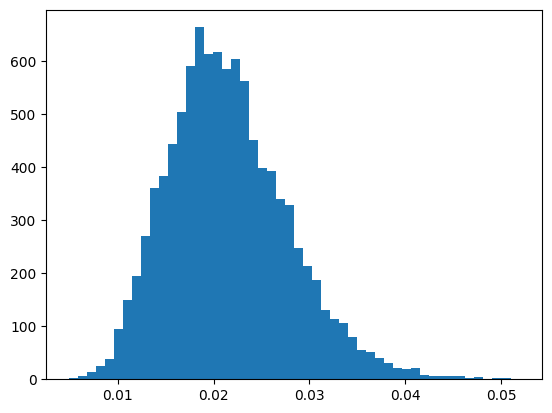

In [12]:
hist(x1[-1])

As seen below, the simulated paths revert to the mean $\theta = 0.02$ 

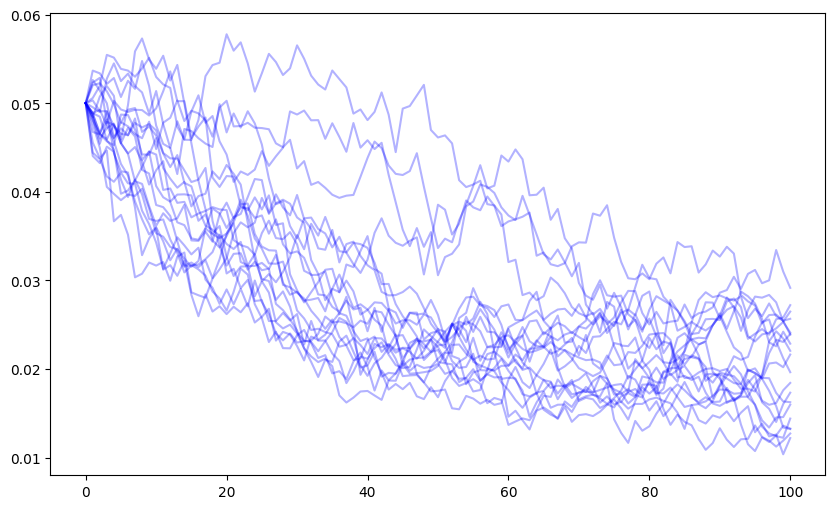

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(x1[:, :20], color="b", alpha=0.3)
plt.show()

## Heston Stochastic Volatility

In [14]:
S0 = 100
r = 0.05
v0 = 0.1
kappa = 3.0
theta = 0.25
sigma = 0.1
rho = 0.6
corr_mat = np.array([[1.0, rho], [rho, 1.0]])
cho_mat = np.linalg.cholesky(corr_mat)
print(cho_mat)

[[1.  0. ]
 [0.6 0.8]]


In [15]:
M = 50
I = 10_000
dt = T / M
ran_num = npr.standard_normal((2, M + 1, I))  # ((Z1,Z2), timesteps, num_simulations)
v = np.zeros_like(ran_num[0])
vh = np.zeros_like(v)

v[0] = v0
vh[0] = v0

for t in range(1, M + 1):
    ran = np.dot(cho_mat, ran_num[:, t, :])
    vh[t] = (vh[t - 1] +
             kappa * (theta - np.maximum(vh[t - 1], 0)) * dt +
             sigma * np.sqrt(np.maximum(vh[t - 1], 0)) * np.sqrt(dt) * ran[1])
v = np.maximum(vh, 0)

In [16]:
v.shape

(51, 10000)

In [17]:
S = np.zeros_like(ran_num[0])
S[0] = S0
for t in range(1, M + 1):
    ran = np.dot(cho_mat, ran_num[:, t, :])
    S[t] = S[t - 1] * np.exp((r - 0.5 * v[t]) * dt + np.sqrt(v[t]) * ran[0] * np.sqrt(dt))

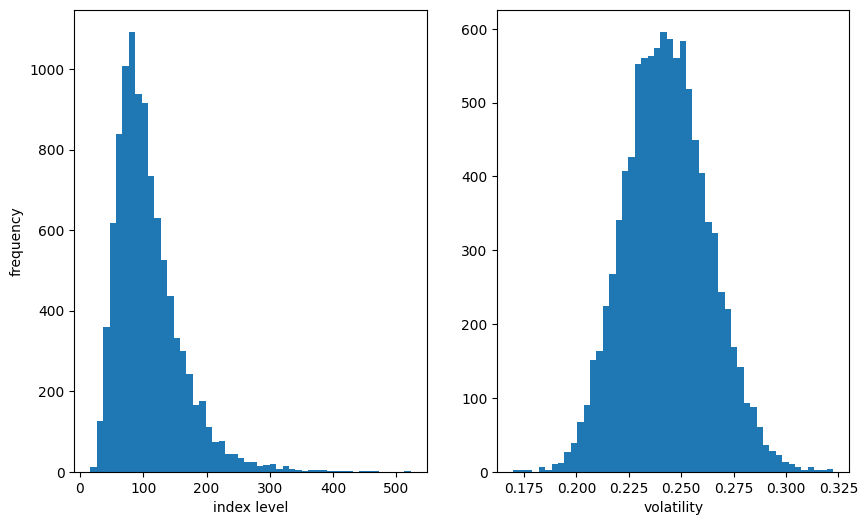

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.hist(S[-1], bins=50)
ax1.set_xlabel('index level')
ax1.set_ylabel('frequency')
ax2.hist(v[-1], bins=50)
ax2.set_xlabel('volatility');

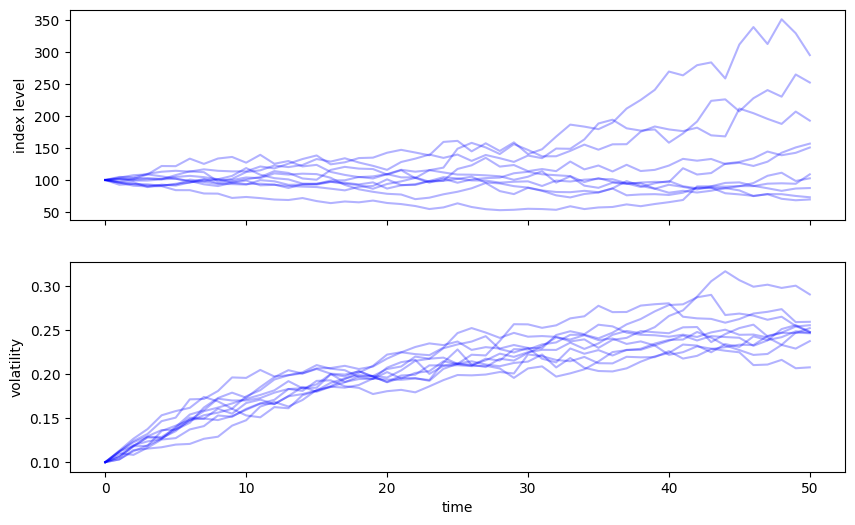

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6))
ax1.plot(S[:, :10], lw=1.5, color="b", alpha=0.3)
ax1.set_ylabel('index level')
ax2.plot(v[:, :10], lw=1.5, color="b", alpha=0.3)
ax2.set_xlabel('time')
ax2.set_ylabel('volatility');